In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Load your data
data = spark.read.format("csv").option("header", "true").load("hdfs://localhost:54310/user/hduser/hdfs-directory/daily_file.csv")

# Example: Drop missing values
data = data.na.drop(subset=["Day", "Confirmed", "Recovered", "Deaths"])

# Selecting features and converting string columns to numeric types
selected_features = data.select(
    col("Day").cast("double"),
    col("Confirmed").cast("double"),
    col("Deaths").cast("double"),
    col("Recovered").cast("double"),
    col("Active").cast("double"),
    col("New Cases").cast("double"),
    col("New Deaths").cast("double"),
    col("New recovered").cast("double")
)

# Assemble features into a single vector column and overwrite the existing column
assembler = VectorAssembler(inputCols=["Day", "Confirmed", "Recovered", "Deaths"], outputCol="features")
data_assembled = assembler.transform(selected_features).select("Day", "Confirmed", "Recovered", "Deaths", "features")

# Split the data into training and test sets
(training_data, test_data) = data_assembled.randomSplit([0.8, 0.2], seed=123)

# Create a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Deaths")

# Create a pipeline
pipeline = Pipeline(stages=[lr])

# Train the model
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Display predictions vs. actual values
predictions.select("Deaths", "prediction").show()



23/11/30 21:49:03 WARN Instrumentation: [73f9c5fe] regParam is zero, which might cause numerical instability and overfitting.


+--------+------------------+
|  Deaths|        prediction|
+--------+------------------+
|    26.0|25.999999999978794|
|   131.0| 130.9999999999559|
|   426.0| 425.9999999999429|
|   492.0|491.99999999994554|
|   906.0| 905.9999999999379|
|  1523.0|1522.9999999999527|
|  2246.0| 2245.999999999869|
|  2250.0|2249.9999999998595|
|  2627.0| 2626.999999999806|
|  2707.0| 2706.999999999787|
|  2767.0|2766.9999999997694|
|  2936.0|2935.9999999997162|
|  3079.0| 3078.999999999686|
|  3981.0|3980.9999999996126|
|  7948.0| 7947.999999999662|
| 16748.0|16747.999999999956|
| 93650.0|  93650.0000000007|
|114620.0|114620.00000000067|
|148591.0|148591.00000000058|
|210862.0|210862.00000000038|
+--------+------------------+
only showing top 20 rows



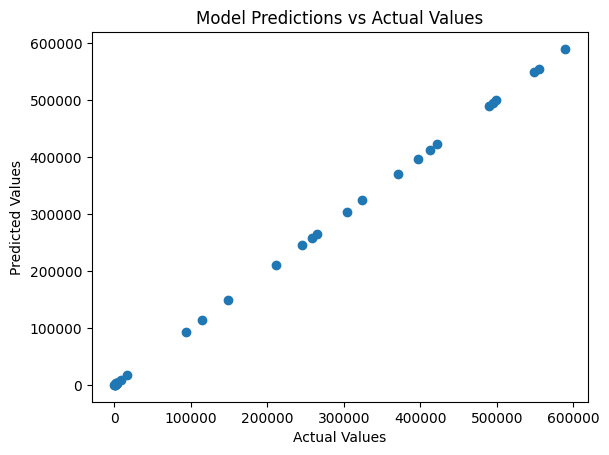

In [9]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt

# Collect actual and predicted values for visualization
actual_values = predictions.select("Deaths").rdd.flatMap(lambda x: x).collect()
predicted_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Visualize predictions vs. actual values
plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs Actual Values")
plt.show()
